# miniGPT PEFT varaint list/plan

To build the six variants for the MiniGPT model, we’ll work within MiniGPT and TransformerLayer to create each variant in the following order.

1. Base MiniGPT - Standard Transformer Architecture

This will be the baseline model with no PEFT applied.

2. LoRA - Low-Rank Adaptation

For LoRA, we’ll adjust only the key, query, or value projections with low-rank updates, stacking LoRA linear layers in SingleHeadAttention.

3. Prefix Tuning (vanilla and Army football personality)

Prefix tuning will prepend trainable embeddings to each layer in the transformer to condition each layer’s computation with prefix tokens.

4. Bias Tuning

Here, only the bias terms will be updated. For this, we enable tuning of biases in the Linear layers without updating any weights.

5. Adapter Layer

An adapter layer will be added as a small bottleneck fully connected layer in each transformer layer, improving flexibility without large parameter costs.

6. LoRA+

This variant, once defined, will combine LoRA with another augmentation.

In [ ]:
# Enable autoreload for modules (if using IPython/Jupyter)
try:
    %load_ext autoreload
    %autoreload 2
except:
    pass  # If not in an interactive environment, ignore

In [ ]:
# dubug.py runs a single varaint of the model with a single set of parameters, only 1 iteration, etc.

# %run debug.py


The base model is a GPT-2 model with the following notable parameters:

- **Model architecture:** GPT-2
- **Number of layers (n_layer):** 12
- **Hidden size (n_embd):** 768
- **Number of attention heads (n_head):** 12
- **Context size (n_ctx):** 1024
- **Vocabulary size (vocab_size):** 50257
- **Dropout rates:** 0.1 for various components (attention, embeddings, residuals)
- **Activation function:** gelu_new
- **Training precision (torch_dtype):** float32
- **About 117M parameters**

Generate some samples using a few select prompts

In [ ]:
%run generate_samples.py

In [ ]:
%run evaluate_models.py

The parameter counts reflect how each Parameter-Efficient Fine-Tuning (PEFT) technique modifies only a small subset of the model’s parameters, rather than fine-tuning all parameters as in the base model. Here’s why the parameter counts and percentages differ so dramatically:

1. **Base Model (100% parameters):**  
   In the "base" variant, no PEFT techniques are applied. This means all parameters are trainable. The parameter count matches the full model—hence 100%.

2. **LoRA and LoRA Plus (~47.65% parameters):**  
   LoRA (Low-Rank Adaptation) inserts small, low-rank adapter matrices into certain layers (e.g., attention projections). Although LoRA is designed to drastically reduce the number of new parameters that need to be trained, it can still end up with a relatively large fraction of parameters trainable if applied to multiple layers or large embeddings. LoRA Plus is similar but may add slightly different scaling or optimization strategies, not drastically changing the parameter count from LoRA.  
   In practice, the fraction here (~47.65%) suggests that LoRA might have been applied to a substantial portion of the model’s layers or a large embedding layer. This might be unusual if LoRA is typically expected to train far fewer parameters. Possibly, the implementation in this context replaced or wrapped large layers, making nearly half the parameters trainable.

3. **Prefix Tuning (~0.01% parameters):**  
   Prefix tuning adds a small set of prefix embeddings to the input sequences of the transformer layers. These prefixes are learned parameters but are tiny compared to the entire model. Typically, prefix embeddings for a few tokens per layer represent only a minuscule fraction of the full model’s parameter count. That’s why the prefix variants show a negligible percentage (~0.01%).

4. **Bias Tuning (~0.03% parameters):**  
   Bias tuning unfreezes only the bias terms of the model’s layers. Since bias parameters are a very small subset of the total parameters (far fewer than weights), this results in only a tiny fraction of total parameters being trainable. Hence ~0.03% is trainable here.

5. **Adapter Tuning (~0.48% parameters):**  
   Adapters insert small feed-forward layers (with a bottleneck) inside each transformer layer. Although relatively small, adapters introduce more parameters than prefix or bias tuning, but still far fewer than fully fine-tuning the whole model. The ~0.48% figure aligns with adapter techniques being quite parameter-efficient but larger than prefix or bias methods due to additional projection layers.

**In Summary:**  
- **Base:** All parameters trainable, so 100%.  
- **LoRA/LoRA Plus:** Introduce low-rank matrices into the model’s layers. Depending on how they’re applied, they can still cover a large portion of parameters. In your case, about half the parameters ended up trainable, suggesting a broad application of LoRA.  
- **Prefix Tuning:** Adds a tiny number of prefix tokens as embeddings, so only a fraction of a percent.  
- **Bias Tuning:** Unfreezes only biases, which are extremely small compared to all weights.  
- **Adapter Tuning:** Adds small adapter layers, increasing parameters more than prefix or bias tuning but still much less than full fine-tuning.

This variety shows how PEFT methods can drastically reduce the fraction of trainable parameters—from half the model for certain LoRA configurations to nearly negligible amounts for prefix and bias tuning—while still enabling effective model adaptation.

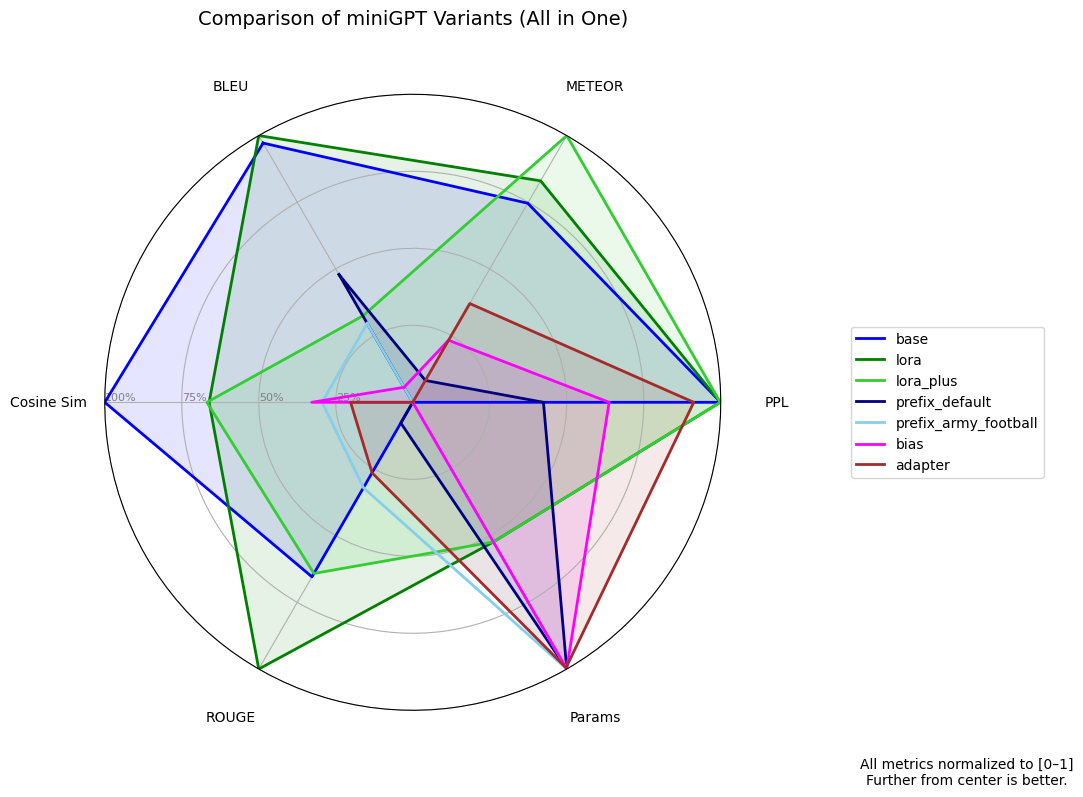

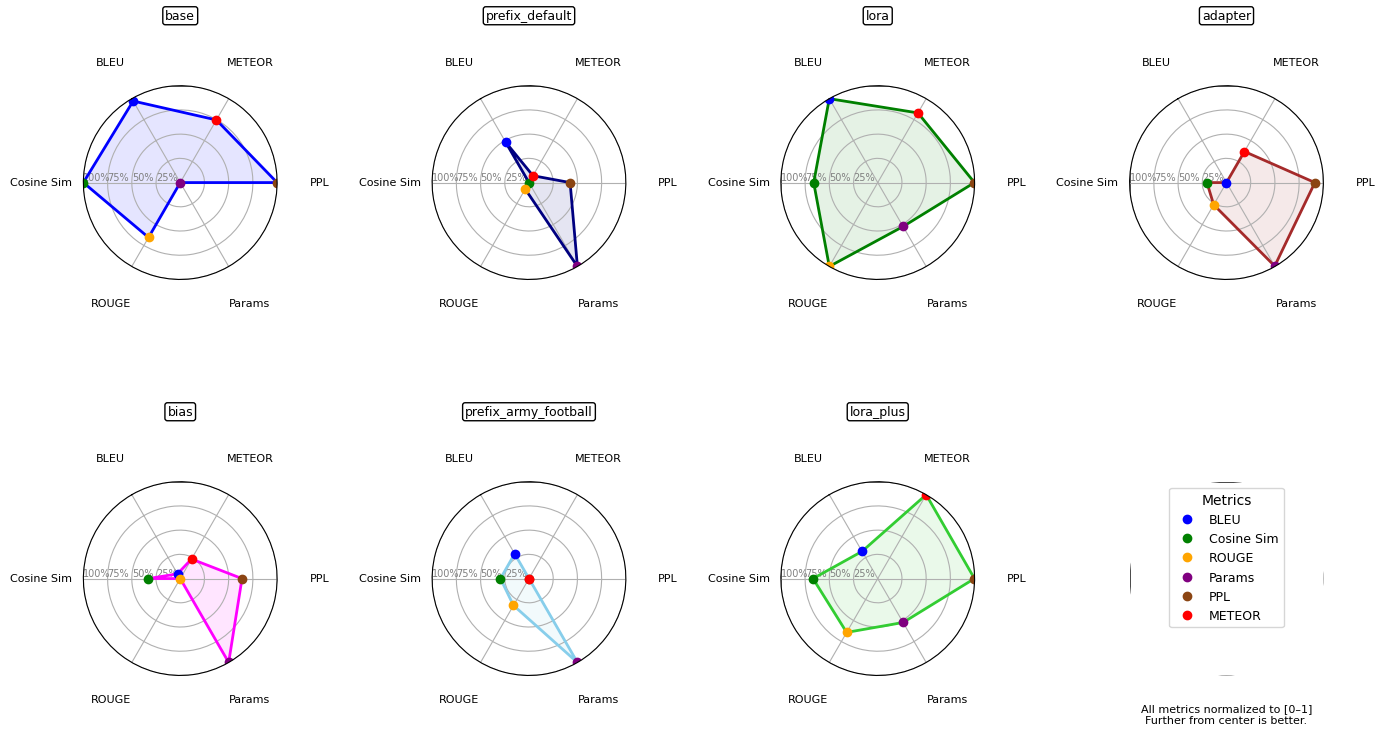

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Hyperparameter for scaling
scale_factor = 1.0

# Updated data table with the new evaluation results:
# Columns: Variant, Trainable Params, % of Full Params, PPL, METEOR, ROUGE, BLEU, Cosine Sim
data_table = [
    ["base", 13722624, 100.00, 5.5616, 0.4417, 0.2572, 0.0931, 0.4533],
    ["lora", 6634436, 47.65, 95.9474, 0.4545, 0.2844, 0.0933, 0.3878],
    ["lora_plus", 6634436, 47.65, 95.9474, 0.4804, 0.2562, 0.0885, 0.3892],
    ["prefix_default", 1280, 0.01, 33286.1, 0.3403, 0.2118, 0.0896, 0.26],
    ["prefix_army_football", 1280, 0.01, 57821.1, 0.3278, 0.2309, 0.0883, 0.3169],
    ["bias", 3712, 0.03, 20954.4, 0.3633, 0.2057, 0.0866, 0.3234],
    ["adapter", 66304, 0.48, 5071.82, 0.3843, 0.2265, 0.0862, 0.299]
]

variants = [row[0] for row in data_table]

# Metrics order: BLEU first
metrics = ["BLEU", "Cosine Sim", "ROUGE", "Params", "PPL", "METEOR"]

raw_bleu = np.array([row[6] for row in data_table])
raw_cosine = np.array([row[7] for row in data_table])
raw_rouge = np.array([row[5] for row in data_table])
raw_params = np.array([row[2] for row in data_table])
raw_ppl = np.array([row[3] for row in data_table])
raw_meteor = np.array([row[4] for row in data_table])

def normalize_higher_better(values):
    min_val, max_val = values.min(), values.max()
    return (values - min_val)/(max_val - min_val) if max_val > min_val else np.ones_like(values)

def normalize_lower_better(values):
    min_val, max_val = values.min(), values.max()
    return (max_val - values)/(max_val - min_val) if max_val > min_val else np.ones_like(values)

bleu_norm = normalize_higher_better(raw_bleu)
cosine_norm = normalize_higher_better(raw_cosine)
rouge_norm = normalize_higher_better(raw_rouge)
params_norm = normalize_lower_better(raw_params)
ppl_norm = normalize_lower_better(raw_ppl)
meteor_norm = normalize_higher_better(raw_meteor)

all_data = np.column_stack([bleu_norm, cosine_norm, rouge_norm, params_norm, ppl_norm, meteor_norm])

N = len(metrics)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

variant_colors = {
    'base': 'blue',
    'lora': 'green',
    'lora_plus': 'limegreen',
    'prefix_default': 'navy',
    'prefix_army_football': 'skyblue',
    'bias': 'magenta',
    'adapter': 'brown'
}

metric_colors = {
    "METEOR": 'red',
    "BLEU": 'blue',
    "Cosine Sim": 'green',
    "ROUGE": 'orange',
    "Params": 'purple',
    "PPL": 'saddlebrown'
}

# Rotate by theta_offset = 120 degrees (pi/2 + 30°)
theta_offset = np.pi/2 + (30 * np.pi/180.0)
rlabel_position_deg = 60.0

# All-in-One Radar Chart
fig_all, ax_all = plt.subplots(figsize=(8*scale_factor,8*scale_factor), subplot_kw=dict(polar=True))
ax_all.set_theta_offset(theta_offset)
ax_all.set_ylim(0,1)
ax_all.grid(True)

ax_all.set_xticks(angles[:-1])
ax_all.set_xticklabels(metrics, color='black', size=10*scale_factor)
ax_all.tick_params(axis='x', pad=30*scale_factor)

ax_all.set_yticks([0.25,0.5,0.75,1.0])
ax_all.set_yticklabels(["25%","50%","75%","100%"], color="grey", size=8*scale_factor)
ax_all.set_rlabel_position(rlabel_position_deg)

for i, variant in enumerate(variants):
    values = all_data[i].tolist() + [all_data[i][0]]
    ax_all.plot(angles, values, linewidth=2, color=variant_colors[variant], label=variant)
    ax_all.fill(angles, values, alpha=0.1, color=variant_colors[variant])

ax_all.set_title("Comparison of miniGPT Variants (All in One)", y=1.1, size=14*scale_factor)
leg = ax_all.legend(loc='center left', bbox_to_anchor=(1.2,0.5), frameon=True)
ax_all.text(1.4, -0.1, "All metrics normalized to [0–1]\nFurther from center is better.", 
            ha='center', va='center', fontsize=10*scale_factor, transform=ax_all.transAxes)


# Individual Variant Plots
subplot_order = [
    'base', 'prefix_default', 'lora', 'adapter',
    'bias', 'prefix_army_football', 'lora_plus', 'legend'
]

fig_individual, axs = plt.subplots(2,4, figsize=(16*scale_factor,8*scale_factor), subplot_kw=dict(polar=True))
fig_individual.subplots_adjust(wspace=0.8, hspace=0.8)

for ax in axs.flat:
    ax.set_theta_offset(theta_offset)
    ax.set_ylim(0,1)
    ax.grid(True)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, color='black', size=8*scale_factor)
    ax.tick_params(axis='x', pad=20*scale_factor)
    ax.set_yticks([0.25,0.5,0.75,1.0])
    ax.set_yticklabels(["25%","50%","75%","100%"], color="grey", size=7*scale_factor)
    ax.set_rlabel_position(rlabel_position_deg)

    rect = plt.Rectangle((0,0),1,1, fill=False, edgecolor='black', lw=0.5, transform=ax.transAxes)
    ax.add_patch(rect)

for i, item in enumerate(subplot_order):
    ax = axs.flat[i]
    if item == 'legend':
        ax.set_axis_off()
        handles = [ax.plot([], [], marker='o', color=metric_colors[m], linestyle='None', label=m)[0] for m in metrics]
        legend = ax.legend(handles=handles, loc='upper center', title="Metrics", fontsize=9*scale_factor, frameon=True)
        ax.text(0.5, -0.2, "All metrics normalized to [0–1]\nFurther from center is better.",
                ha='center', va='center', fontsize=8*scale_factor, transform=ax.transAxes)
        continue

    idx = variants.index(item)
    values = all_data[idx].tolist() + [all_data[idx][0]]
    ax.plot(angles, values, linewidth=2, color=variant_colors[item])
    ax.fill(angles, values, alpha=0.1, color=variant_colors[item])

    for m_idx, metric_name in enumerate(metrics):
        ax.plot(angles[m_idx], all_data[idx][m_idx], marker='o', color=metric_colors[metric_name], markersize=6*scale_factor)

    # Title in a box, higher up
    ax.set_title(item, y=1.3, size=9*scale_factor,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

plt.show()
